**RAG Response Generation, Visuals, and Weights & Biases Experiment Tracking**

Requires OpenAI and WandB keys to be stored in .env file in subfolder 'environment', see below loading code.

Python 3.10 used to satisfy LangChain text splitter function needs.

In [1]:
# !pip install langchain
# !pip install python-dotenv
# !pip install openai --upgrade
# !pip install umap-learn
# !pip install plotly
# !pip install WandB
# !pip install bokeh

In [18]:
import os
import pickle
import textwrap
import time

from dotenv import load_dotenv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
import seaborn as sns
import umap
import wandb

from bokeh.io import push_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, HoverTool, Slider
from bokeh.plotting import curdoc, figure, output_notebook, show

from langchain.text_splitter import RecursiveCharacterTextSplitter

from openai import OpenAI

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


In [19]:
# Load API keys for OpenAI and WandB

# Path to openai .env file
env_path = "/work/environment/api_keys.env"

# Load environment variables from specified .env file
load_dotenv(dotenv_path=env_path)

# OpenAI
client = OpenAI(
    api_key=os.environ[
        "OPENAI_API_KEY"
    ],  # this is the new default
)

# Initialize Weights & Biases
wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb.init(project="RAG_M2_prototyping")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


query,What were key events...
response_with_augmentation,The provided informa...
response_without_augmentation,1. Enron's stock pri...




**Load via one of the below**

In [4]:
# final_df = pd.read_csv('/work/data/final_combined_df.csv')

In [5]:
# Or load from pickle

file_path = '/work/data/final_combined_df.pkl'

final_df = pd.read_pickle(file_path)

print(final_df.head())

                                           GroupName  \
0  The Objectives And Roots Of The Scheme To Defraud   
1  Use of Special Purpose Entities and LJM Partne...   
2                        Creation of LJM Partnership   
3                                    "Raptor" Hedges   
4  Manufacturing Earnings and Concealing Debt thr...   

                                        grouped_text  
0  The objectives of the scheme to defraud carrie...  
1  As part of the scheme to defraud, Skilling, Ca...  
2  In June 1999, Skilling, Causey, and others sou...  
3  Beginning in the spring of 2000, Enron and LJM...  
4  In addition to the fraudulent Raptor hedging d...  


If you have changed the documents files or intend to vary the chunking strategy make sure you delete the old embeddings.pkl if it is still in the data subdirectory or you will get a mismatch error. It will load the old embeddings but the rows won't match your new chunked_df.

Modify the below to match your Weights & Biases account.

In [6]:
# Initialize W&B with a private project
# Using "successmotions" as entity will log to personal (free tier) account
# Using "umich_MADS-org" as entity will log to the other (academic tier) account
wandb.init(
    project="M2RAG test01",
    entity="successmotions",
    config={
        "chunk_size": 400,
        "chunk_overlap": 100,
        "embedding_model": "text-embedding-ada-002",
        "generation_model": "gpt-3.5-turbo",
        "batch_size": 100,
        "top_k": 10,
    },
)

# Configuration
config = wandb.config

In [7]:
# Create the chunked_df
# Combine GroupName and grouped_text
final_df["combined_text"] = final_df["GroupName"] + ": " + final_df["grouped_text"]

# Initialize RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=config.chunk_size, chunk_overlap=config.chunk_overlap
)

# Chunk the text and keep track of GroupName as metadata for possible later use
chunked_texts = []
metadata = []

for index, row in final_df.iterrows():
    chunks = text_splitter.split_text(row["combined_text"])
    chunked_texts.extend(chunks)
    metadata.extend([row["GroupName"]] * len(chunks))

# Create a DataFrame with chunked texts and metadata
chunked_df = pd.DataFrame({"chunked_text": chunked_texts, "GroupName": metadata})

# Save chunked data as an artifact
output_path = "/work/data/chunked_groupnames_with_metadata.csv"
chunked_df.to_csv(output_path, index=False)
chunked_data_artifact = wandb.Artifact("chunked_data", type="dataset")
chunked_data_artifact.add_file(output_path)
wandb.log_artifact(chunked_data_artifact)

<Artifact chunked_data>

In [20]:
# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


# Save embeddings to a pickle file
def save_embeddings_to_file(embeddings, filename):
    if filename:
        with open(filename, "wb") as f:
            pickle.dump(embeddings, f)
    return {"status": "success"}


# Load embeddings from a pickle file
def load_embeddings_from_file(filename):
    if filename and os.path.exists(filename):
        with open(filename, "rb") as f:
            return pickle.load(f)
    return None


# Get embeddings using the new API in batches and save/load them to/from a file
def get_embeddings_in_batches(
    texts, batch_size=config.batch_size, filename="/work/data/embeddings.pkl"
):
    # Try to load existing embeddings
    embeddings = load_embeddings_from_file(filename)
    if embeddings is not None:
        print("Loaded embeddings from file.")
        return embeddings

    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        try:
            print(
                f"Processing batch {i // batch_size + 1}/{(len(texts) + batch_size - 1) // batch_size}"
            )
            response = client.embeddings.create(
                model=config.embedding_model, input=batch_texts
            )
            embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(embeddings)
        except Exception as e:
            print(f"Failed to generate embeddings for batch {i // batch_size + 1}: {e}")

    # Save embeddings to file
    save_embeddings_to_file(all_embeddings, filename)
    return all_embeddings


# Generate embeddings for text data in batches
embeddings = get_embeddings_in_batches(chunked_df["chunked_text"].tolist())

# Debugging: Check lengths
print("Generated embeddings length:", len(embeddings))
print("Chunked DataFrame length:", len(chunked_df))

if len(embeddings) != len(chunked_df):
    print("Embeddings and chunked_df length mismatch!")
    print(f"Number of embeddings: {len(embeddings)}")
    print(f"Number of rows in chunked_df: {len(chunked_df)}")
    raise ValueError(
        "The number of embeddings does not match the number of rows in chunked_df"
    )

chunked_df["embeddings"] = embeddings

# Save embeddings as an artifact
embeddings_artifact = wandb.Artifact("embeddings", type="model")
embeddings_artifact.add_file("/work/data/embeddings.pkl")
wandb.log_artifact(embeddings_artifact)

# Store embeddings and metadata in a list of dictionaries
documents = []
for index, row in chunked_df.iterrows():
    documents.append(
        {
            "GroupName": row["GroupName"],
            "chunked_text": row["chunked_text"],
            "embedding": row["embeddings"],
        }
    )


# Retrieve relevant documents and their similarity scores
def retrieve_documents(query, documents, top_k=config.top_k):
    query_embedding = get_embeddings_in_batches([query], batch_size=1, filename=None)[0]
    similarities = []

    for doc in documents:
        similarity = cosine_similarity([query_embedding], [doc["embedding"]])
        similarities.append((doc, similarity[0][0]))

    sorted_docs = sorted(similarities, key=lambda x: x[1], reverse=True)
    retrieved_docs = [doc[0] for doc in sorted_docs[:top_k]]
    similarity_scores = [doc[1] for doc in sorted_docs[:top_k]]
    return retrieved_docs, similarity_scores


# Generate response with document augmentation
def generate_response_with_augmentation(query, documents):
    relevant_docs, similarity_scores = retrieve_documents(query, documents)
    messages = [
        {"role": "user", "content": query},
    ]
    for doc in relevant_docs:
        messages.append({"role": "user", "content": doc["chunked_text"]})
    try:
        response = client.chat.completions.create(
            model=config.generation_model, messages=messages, max_tokens=550
        )
        response_dict = response.model_dump()
        result = response_dict["choices"][0]["message"]["content"].strip()
        return result, similarity_scores, relevant_docs
    except Exception as e:
        print("Failed to generate response:", e)
        return None, None, None


# Generate response without document augmentation
def generate_response_without_augmentation(query):
    messages = [
        {"role": "user", "content": query},
    ]
    try:
        response = client.chat.completions.create(
            model=config.generation_model, messages=messages, max_tokens=550
        )
        response_dict = response.model_dump()
        result = response_dict["choices"][0]["message"]["content"].strip()
        return result
    except Exception as e:
        print("Failed to generate response:", e)
        return None


# Wrap text every n words
def wrap_text(text, n=6):
    words = text.split()
    wrapped_text = "\n".join(
        [" ".join(words[i : i + n]) for i in range(0, len(words), n)]
    )
    return wrapped_text


# Plot cosine similarity scores with labels
def plot_similarity_scores(query, similarity_scores, relevant_docs):
    group_names = [wrap_text(doc["GroupName"]) for doc in relevant_docs]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(similarity_scores)), similarity_scores, color="blue")
    plt.xlabel("Document GroupName")
    plt.ylabel("Cosine Similarity Score")
    plt.title(f'Cosine Similarity Scores for Query: "{query}"')
    plt.xticks(range(len(similarity_scores)), group_names, rotation=45, ha="right")

    for bar, score in zip(bars, similarity_scores):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{score:.2f}",
            ha="center",
            va="center",
            color="white",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()


# Log responses to WandB
def log_responses(query, response_with_augmentation, response_without_augmentation):
    wandb.log(
        {
            "query": query,
            "response_with_augmentation": response_with_augmentation,
            "response_without_augmentation": response_without_augmentation,
        }
    )


# Update comparison dataframe with new responses
def update_comparison_df(
    query, response_with_augmentation, response_without_augmentation, comparison_df_path
):
    # Load existing comparison dataframe if it exists
    if os.path.exists(comparison_df_path):
        comparison_df = pd.read_csv(comparison_df_path)
    else:
        comparison_df = pd.DataFrame(
            columns=[
                "Query",
                "Response Without Augmentation",
                "Response With Augmentation",
            ]
        )

    # Append new responses
    new_row = pd.DataFrame(
        {
            "Query": [query],
            "Response Without Augmentation": [response_without_augmentation],
            "Response With Augmentation": [response_with_augmentation],
        }
    )
    comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

    # Save updated dataframe back to the file
    comparison_df.to_csv(comparison_df_path, index=False)
    return comparison_df

Loaded embeddings from file.
Generated embeddings length: 2515
Chunked DataFrame length: 2515


Processing batch 1/1
Number of retrieved documents: 10
Document 1: {'GroupName': 'A Sudden Collapse July 2001 to ??', 'chunked_text': "A Sudden Collapse July 2001 to ??: 2001 July - New CEO Skilling is hit in the face with pie by a protester who blamed Enron for California's energy crisis.  California consumer groups and politicians accused Enron of price gouging during California's power short- age. Enron stock drops to $42.93. 22  2001 July - As the California power crisis provokes rolling blackouts, Pacific Gas and Electric", 'embedding': [-0.005097780376672745, -0.045385390520095825, 0.014119001105427742, -0.01843949593603611, -0.02831875905394554, -0.005535213742405176, -0.0003505775530356914, 0.008694828487932682, -0.003235324053093791, -0.036663640290498734, 0.020889123901724815, 0.03012233041226864, 0.019395120441913605, 0.008990936912596226, 0.0010683467844501138, 0.006672540679574013, 0.014859273098409176, -0.01821068488061428, 0.004488738719373941, 0.0006733949412591755, -0.

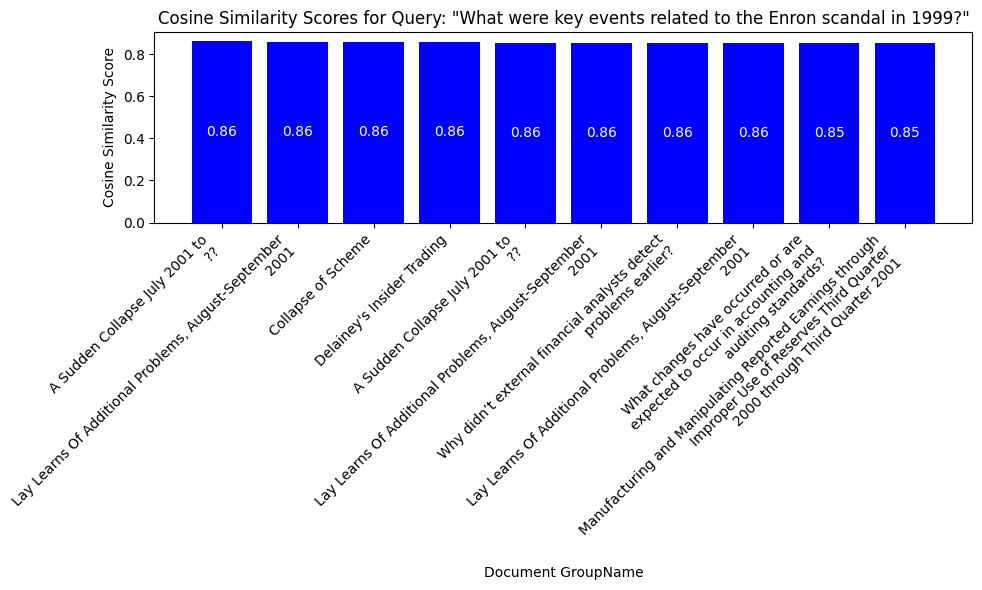

Responses generated and stored for comparison.


Augmented Generation:
 The Enron scandal in 1999 led to significant changes in accounting and auditing standards. Some of
the key changes and developments that occurred or were expected to occur after the scandal include:
1. **Increased Regulatory Oversight**: The Enron scandal prompted increased regulatory oversight and
led to the implementation of measures such as the Sarbanes-Oxley Act (SOX) in 2002. SOX introduced
stricter financial reporting requirements, increased accountability of corporate boards and
executives, and enhanced auditor independence.  2. **Enhanced Auditor Independence**: The scandal
highlighted the importance of maintaining auditor independence to ensure the accuracy and
reliability of financial statements. Regulatory bodies and standard-setting organizations introduced
rules to enhance auditor independence and reduce conflicts of interest.  3. **Improved Transparency
and Disclosure**: The Enron scandal exposed the 

In [21]:
# Create a test query
test_query = "What were key events related to the Enron scandal in 1999?"

# Generate response with augmentation and get similarity scores
response_with_augmentation, similarity_scores, relevant_docs = (
    generate_response_with_augmentation(test_query, documents)
)

print(f"Number of retrieved documents: {len(similarity_scores)}")

# Optionally, print the retrieved documents to inspect
for i, doc in enumerate(relevant_docs):
    print(f"Document {i+1}: {doc}")

# Plot the similarity scores
plot_similarity_scores(test_query, similarity_scores, relevant_docs)

# Generate response without augmentation
response_without_augmentation = generate_response_without_augmentation(test_query)

# Path to save the comparison dataframe
comparison_df_path = "/work/data/response_comparison.csv"

# Update the comparison dataframe with the new responses
comparison_df = update_comparison_df(
    test_query,
    response_with_augmentation,
    response_without_augmentation,
    comparison_df_path,
)

# Log the responses
log_responses(test_query, response_with_augmentation, response_without_augmentation)

# Save the updated comparison dataframe as an artifact
comparison_df_artifact = wandb.Artifact("response_comparison", type="dataset")
comparison_df_artifact.add_file(comparison_df_path)
wandb.log_artifact(comparison_df_artifact)

print("Responses generated and stored for comparison.\n\n")
print(
    "Augmented Generation:\n",
    textwrap.fill(response_with_augmentation, width=100),
    "\n\n",
)
print(
    "Unaugmented Generation:\n", textwrap.fill(response_without_augmentation, width=100)
)

Visualizing the embeddings

Dendrogram interactive with plotly did not work well, so used Bokeh.

In [22]:
# Assumes chunked_df and embeddings are loaded

# Ensure the DataFrame has the same number of rows as embeddings
assert len(chunked_df) == len(embeddings)

In [23]:
# Copy necessary DataFrame to avoid modifying the original
dendrogram_df = chunked_df.copy()

# Convert embeddings to a NumPy array if they aren't already
dendrogram_embeddings = np.array(embeddings)

# Perform hierarchical clustering
Z_dendrogram = linkage(dendrogram_embeddings, method="ward")

# Extract group names
dendrogram_group_names = dendrogram_df["GroupName"].tolist()

# Create dendrogram
dendro = sch.dendrogram(Z_dendrogram, labels=dendrogram_group_names, no_plot=True)

# Extract coordinates for Bokeh
icoord = np.array(dendro["icoord"])
dcoord = np.array(dendro["dcoord"])
labels = np.array(dendro["ivl"])

# Create Bokeh data source
x_values = []
y_values = []
group_labels = []
for i in range(len(icoord)):
    x_values.extend(icoord[i])
    y_values.extend(dcoord[i])
    group_labels.extend([labels[i // 2]] * 4)  # Repeat the groupname for each segment

source = ColumnDataSource({"x": x_values, "y": y_values, "group": group_labels})

# Create Bokeh figure
output_notebook()
p = figure(
    title="Interactive Dendrogram with Group Names",
    width=1200,
    height=800,
    x_axis_label="Cluster Merge Steps",
    y_axis_label="Distance",
)

# Add lines for dendrogram
p.line(x="x", y="y", source=source, line_width=2)

# Add hover tool
hover = HoverTool(tooltips=[("Group", "@group")])
p.add_tools(hover)

# Customize plot appearance
p.xaxis.major_label_orientation = 1.0  # Rotate x-axis labels for better readability

show(p)

Loading BokehJS ...

New Interactive zooming dendro

In [24]:
# Assuming chunked_df and embeddings are already defined

# Copy necessary DataFrame to avoid modifying the original
dendrogram_df = chunked_df.copy()

# Convert embeddings to a NumPy array if they aren't already
dendrogram_embeddings = np.array(embeddings)

# Perform hierarchical clustering
Z_dendrogram = linkage(dendrogram_embeddings, method="ward")

# Extract groupnames
dendrogram_group_names = dendrogram_df["GroupName"].tolist()

# Create dendrogram
dendro = sch.dendrogram(Z_dendrogram, labels=dendrogram_group_names, no_plot=True)

# Extract coordinates for Bokeh
icoord = np.array(dendro["icoord"])
dcoord = np.array(dendro["dcoord"])
labels = np.array(dendro["ivl"])

# Create Bokeh data source
x_values = []
y_values = []
group_labels = []
for i in range(len(icoord)):
    x_values.extend(icoord[i])
    y_values.extend(dcoord[i])
    group_labels.extend([labels[i // 2]] * 4)  # Repeat the group name for each segment

source = ColumnDataSource({"x": x_values, "y": y_values, "group": group_labels})

# Create Bokeh figure
output_notebook()
p = figure(
    title="Interactive Dendrogram with Group Names",
    width=1200,
    height=800,
    x_axis_label="Cluster Merge Steps",
    y_axis_label="Distance",
    tools="",
)

# Add lines for dendrogram
p.line(x="x", y="y", source=source, line_width=2)

# Add hover tool
hover = HoverTool(tooltips=[("Group", "@group")])
p.add_tools(hover)

# Add tools for interactivity
p.add_tools(BoxZoomTool(), PanTool(), ResetTool())

# Set active tools
p.toolbar.active_drag = PanTool()
p.toolbar.active_scroll = "auto"  # Enable both wheel zoom and box zoom

# Customize plot appearance
p.xaxis.major_label_orientation = 1.0  # Rotate x-axis labels for better readability

show(p)

Loading BokehJS ...

Treemap to show the hierarchy now as new visual of same info.

In [25]:
# Assuming chunked_df and embeddings are already defined

# Copy necessary DataFrame to avoid modifying the original
dendrogram_df = chunked_df.copy()

# Convert embeddings to a NumPy array if they aren't already
dendrogram_embeddings = np.array(embeddings)

# Perform hierarchical clustering
Z_dendrogram = linkage(dendrogram_embeddings, method="ward")

# Extract group names
dendrogram_df["GroupName"] = dendrogram_df["GroupName"].astype(str)

# Create a DataFrame for treemap visualization
# Assign each data point to a cluster
num_clusters = 10  # Choose number of clusters
dendrogram_df["Cluster"] = fcluster(Z_dendrogram, num_clusters, criterion="maxclust")

# Prepare data for the treemap
treemap_df = dendrogram_df.copy()
treemap_df["Parent"] = "Root"

# Collect cluster names to add to the DataFrame
clusters = []
for cluster in range(1, num_clusters + 1):
    cluster_indices = treemap_df[treemap_df["Cluster"] == cluster].index
    cluster_name = f"Cluster {cluster}"
    treemap_df.loc[cluster_indices, "Parent"] = cluster_name
    clusters.append({"GroupName": cluster_name, "Parent": "Root", "Cluster": -1})

# Create DataFrame for clusters
clusters_df = pd.DataFrame(clusters)

# Add clusters and root element to the DataFrame
treemap_df = pd.concat([treemap_df, clusters_df], ignore_index=True)
treemap_df = pd.concat(
    [treemap_df, pd.DataFrame([{"GroupName": "Root", "Parent": "", "Cluster": -2}])],
    ignore_index=True,
)

# Create treemap using the path parameter
fig = px.treemap(
    treemap_df, path=["Parent", "GroupName"], title="Treemap of Hierarchical Data"
)

fig.show()

Fixed title being replaced by dropdown values

In [26]:
## UMAP with defualt Euclidean distance

query = test_query

# Ensure DataFrame has same number of rows as embeddings
assert len(chunked_df) == len(embeddings)


# Function to get a single embedding
def get_query_embedding(query):
    query_embedding = get_embeddings_in_batches([query], batch_size=1, filename=None)[0]
    return query_embedding


# Generate query embedding
query_embedding = get_query_embedding(query)

# Append query embedding to embeddings list
all_embeddings_with_query = embeddings + [query_embedding]

# Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
umap_embeddings = umap_reducer.fit_transform(all_embeddings_with_query)

# Make copy of chunked_df to preserve original DataFrame
chunked_df_copy = chunked_df.copy()

# Add UMAP embeddings to copied DataFrame
chunked_df_copy["UMAP1"] = umap_embeddings[:-1, 0]
chunked_df_copy["UMAP2"] = umap_embeddings[:-1, 1]
chunked_df_copy["UMAP3"] = umap_embeddings[:-1, 2]

# Add a row for query embedding
query_row = pd.DataFrame(
    {
        "GroupName": ["Query"],
        "UMAP1": [umap_embeddings[-1, 0]],
        "UMAP2": [umap_embeddings[-1, 1]],
        "UMAP3": [umap_embeddings[-1, 2]],
        "is_retrieved": [False],
    }
)
chunked_df_copy = pd.concat([chunked_df_copy, query_row], ignore_index=True)

# Create list of indices for retrieved documents
retrieved_indices = [
    chunked_df_copy.index[chunked_df_copy["chunked_text"] == doc["chunked_text"]][0]
    for doc in relevant_docs
]

# Mark retrieved documents with new column
chunked_df_copy["is_retrieved"] = chunked_df_copy.index.isin(retrieved_indices)

# Add a special mark for query embedding
chunked_df_copy.loc[chunked_df_copy["GroupName"] == "Query", "is_retrieved"] = "Query"

# Create an interactive 3D scatter plot using Plotly with tooltips for GroupName
fig = px.scatter_3d(
    chunked_df_copy,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="is_retrieved",
    color_discrete_map={False: "blue", True: "red", "Query": "black"},
    custom_data=["GroupName"],
    title="UMAP Projection of Embeddings in 3D with GroupName Tooltip",
    labels={
        "UMAP1": "UMAP Dimension 1",
        "UMAP2": "UMAP Dimension 2",
        "UMAP3": "UMAP Dimension 3",
    },
)

# Customize hover template to display only GroupName and move tooltip off to the side
fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>",  # Only show GroupName
    marker=dict(size=5),
    selector=dict(mode="markers"),
)

# Update layout to make figure larger and position dropdown and legend on left side
fig.update_layout(
    width=1000,
    height=800,
    title={
        "text": "UMAP Projection of Embeddings in 3D with GroupName Tooltip",
        "y": 0.95,  # Adjust the title position
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Show All",
                    "method": "update",
                    "args": [{"visible": [True, True, True]}],
                },
                {
                    "label": "Show Red and Black Only",
                    "method": "update",
                    "args": [{"visible": [False, True, True]}],
                },
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.01,  # Positioning the dropdown menu slightly to the right
            "xanchor": "left",
            "y": 0.85,  # Positioning the dropdown menu below the title
            "yanchor": "top",
        }
    ],
    legend=dict(
        x=0.01,  # Positioning the legend on the left
        xanchor="left",
        y=0.75,  # Positioning the legend below the dropdown
        yanchor="top",
    ),
)

# Update hover label properties to have a highly transparent background and black text
fig.update_traces(
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.1)",  # 0.1 Transparency not working - see if possible
        font_color="black", 
        align="left",  # Align text to left, doesn't work in all cases, or maybe at all
    )
)

fig.show()

# Save plot to an HTML file
import plotly.io as pio

output_html_path = "/work/data/umap_3d_plot.html"
pio.write_html(fig, file=output_html_path)

print(f"Interactive 3D plot saved to {output_html_path}")

Processing batch 1/1
/tmp/ipykernel_112/3134780736.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Query' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



Interactive 3D plot saved to /work/data/umap_3d_plot.html


Now with cosine similarity instead of euclidean distance in the UMAP.

In [27]:
## UMAP with cosine similarity - same as RAG retrieve

query = test_query

# Ensure DataFrame has same number of rows as embeddings
assert len(chunked_df) == len(embeddings)


# Function to get a single embedding
def get_query_embedding(query):
    query_embedding = get_embeddings_in_batches([query], batch_size=1, filename=None)[0]
    return query_embedding


# Generate query embedding
query_embedding = get_query_embedding(query)

# Append query embedding to embeddings list
all_embeddings_with_query = embeddings + [query_embedding]

# Apply UMAP for dimensionality reduction to 3D
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric="cosine")
umap_embeddings = umap_reducer.fit_transform(all_embeddings_with_query)

# Make copy chunked_df to preserve original DataFrame
chunked_df_copy = chunked_df.copy()

# Add UMAP embeddings to copied DataFrame
chunked_df_copy["UMAP1"] = umap_embeddings[:-1, 0]
chunked_df_copy["UMAP2"] = umap_embeddings[:-1, 1]
chunked_df_copy["UMAP3"] = umap_embeddings[:-1, 2]

# Add row for query embedding
query_row = pd.DataFrame(
    {
        "GroupName": ["Query"],
        "UMAP1": [umap_embeddings[-1, 0]],
        "UMAP2": [umap_embeddings[-1, 1]],
        "UMAP3": [umap_embeddings[-1, 2]],
        "is_retrieved": [False],
    }
)
chunked_df_copy = pd.concat([chunked_df_copy, query_row], ignore_index=True)

# Create list of indices retrieved documents
retrieved_indices = [
    chunked_df_copy.index[chunked_df_copy["chunked_text"] == doc["chunked_text"]][0]
    for doc in relevant_docs
]

# Mark retrieved documents new column
chunked_df_copy["is_retrieved"] = chunked_df_copy.index.isin(retrieved_indices)

# Add special mark for the query embedding
chunked_df_copy.loc[chunked_df_copy["GroupName"] == "Query", "is_retrieved"] = "Query"

# Create interactive 3D scatter plot using Plotly with tooltips for GroupName
fig = px.scatter_3d(
    chunked_df_copy,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="is_retrieved",
    color_discrete_map={False: "blue", True: "red", "Query": "black"},
    custom_data=["GroupName"],
    title="UMAP Projection of Embeddings in 3D with GroupName Tooltip",
    labels={
        "UMAP1": "UMAP Dimension 1",
        "UMAP2": "UMAP Dimension 2",
        "UMAP3": "UMAP Dimension 3",
    },
)

# Customize hover template to display only GroupName and move tooltip off to side
fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>",  # Only show GroupName
    marker=dict(size=5),
    selector=dict(mode="markers"),
)

# Update layout to make figure larger and position dropdown and legend on left side
fig.update_layout(
    width=1000,
    height=800,
    title={
        "text": "UMAP Projection of Embeddings in 3D with GroupName Tooltip",
        "y": 0.95,  # Adjust the title position
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Show All",
                    "method": "update",
                    "args": [{"visible": [True, True, True]}],
                },
                {
                    "label": "Show Red and Black Only",
                    "method": "update",
                    "args": [{"visible": [False, True, True]}],
                },
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.01,  # Positioning the dropdown menu slightly to the right
            "xanchor": "left",
            "y": 0.85,  # Positioning the dropdown menu below the title
            "yanchor": "top",
        }
    ],
    legend=dict(
        x=0.01,  # Positioning the legend on the left
        xanchor="left",
        y=0.75,  # Positioning the legend below the dropdown
        yanchor="top",
    ),
)

# Update hover label properties to have highly transparent background and black text
fig.update_traces(
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.1)",  # 0.1 Transparency not working - see if possible
        font_color="black", 
        align="left",  # Align text to left, doesn't work in all cases, or maybe at all
    )
)

fig.show()

# Save plot to an HTML file
import plotly.io as pio

output_html_path = "/work/data/umap_cos_3d_plot.html"
pio.write_html(fig, file=output_html_path)

print(f"Interactive 3D plot saved to {output_html_path}")

Processing batch 1/1
/tmp/ipykernel_112/1102601170.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Query' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



Interactive 3D plot saved to /work/data/umap_cos_3d_plot.html


**Now same but with t-SNE**

In [28]:
# TSNE with default Euclidean distance

query = test_query

# Ensure DataFrame has same number of rows as embeddings
assert len(chunked_df) == len(embeddings)


# Function to get a single embedding for t-SNE plot
def get_query_embedding_tsne(query):
    query_embedding_tsne = get_embeddings_in_batches(
        [query], batch_size=1, filename=None
    )[0]
    return query_embedding_tsne


# Generate query embedding for t-SNE plot
query_embedding_tsne = get_query_embedding_tsne(query)

# Append query embedding to the embeddings list for t-SNE plot
all_embeddings_with_query_tsne = embeddings + [query_embedding_tsne]

# Convert embeddings list to NumPy array
all_embeddings_with_query_tsne = np.array(all_embeddings_with_query_tsne)

# Apply t-SNE for dimensionality reduction to 3D
tsne_reducer = TSNE(n_components=3)
tsne_embeddings = tsne_reducer.fit_transform(all_embeddings_with_query_tsne)

# Make a copy of chunked_df to preserve the original DataFrame for t-SNE plot
chunked_df_copy_tsne = chunked_df.copy()

# Add t-SNE embeddings to copied DataFrame
chunked_df_copy_tsne["TSNE1"] = tsne_embeddings[:-1, 0]
chunked_df_copy_tsne["TSNE2"] = tsne_embeddings[:-1, 1]
chunked_df_copy_tsne["TSNE3"] = tsne_embeddings[:-1, 2]

# Add a row for query embedding
query_row_tsne = pd.DataFrame(
    {
        "GroupName": ["Query"],
        "TSNE1": [tsne_embeddings[-1, 0]],
        "TSNE2": [tsne_embeddings[-1, 1]],
        "TSNE3": [tsne_embeddings[-1, 2]],
        "is_retrieved": [False],
    }
)
chunked_df_copy_tsne = pd.concat(
    [chunked_df_copy_tsne, query_row_tsne], ignore_index=True
)

# Create a list of indices for retrieved documents
retrieved_indices_tsne = [
    chunked_df_copy_tsne.index[
        chunked_df_copy_tsne["chunked_text"] == doc["chunked_text"]
    ][0]
    for doc in relevant_docs
]

# Mark retrieved documents with new column
chunked_df_copy_tsne["is_retrieved"] = chunked_df_copy_tsne.index.isin(
    retrieved_indices_tsne
)

# Add special mark for query embedding
chunked_df_copy_tsne.loc[
    chunked_df_copy_tsne["GroupName"] == "Query", "is_retrieved"
] = "Query"

# Create interactive 3D scatter plot using Plotly with tooltips for GroupName
fig_tsne = px.scatter_3d(
    chunked_df_copy_tsne,
    x="TSNE1",
    y="TSNE2",
    z="TSNE3",
    color="is_retrieved",
    color_discrete_map={False: "blue", True: "red", "Query": "black"},
    custom_data=["GroupName"],
    title="t-SNE Projection of Embeddings in 3D with GroupName Tooltip",
    labels={
        "TSNE1": "t-SNE Dimension 1",
        "TSNE2": "t-SNE Dimension 2",
        "TSNE3": "t-SNE Dimension 3",
    },
)

# Customize hover template to display only GroupName and move tooltip off to side
fig_tsne.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>",  # Only show GroupName
    marker=dict(size=5),
    selector=dict(mode="markers"),
)

# Update layout to make figure larger and position dropdown and legend on left side
fig_tsne.update_layout(
    width=1000,
    height=800,
    title={
        "text": "t-SNE Projection of Embeddings in 3D with GroupName Tooltip",
        "y": 0.95,  # Adjust the title position
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    updatemenus=[
        {
            "buttons": [
                {
                    "label": "Show All",
                    "method": "update",
                    "args": [{"visible": [True, True, True]}],
                },
                {
                    "label": "Show Red and Black Only",
                    "method": "update",
                    "args": [{"visible": [False, True, True]}],
                },
            ],
            "direction": "down",
            "showactive": True,
            "x": 0.01,  # Positioning dropdown menu slightly to the right
            "xanchor": "left",
            "y": 0.85,  # Positioning dropdown menu below the title
            "yanchor": "top",
        }
    ],
    legend=dict(
        x=0.01,  # Positioning legend on the left
        xanchor="left",
        y=0.75,  # Positioning legend below the dropdown
        yanchor="top",
    ),
)

# Update hover label properties to have a highly transparent background and black text
fig_tsne.update_traces(
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.1)",  # 0.1 Transparency not working - see if possible
        font_color="black",  
        align="left",  # Align text to the left, doesn't work in all cases, or maybe at all
    )
)

fig_tsne.show()

# Save plot to HTML file
import plotly.io as pio

output_html_path_tsne = "/work/data/tsne_3d_plot.html"
pio.write_html(fig_tsne, file=output_html_path_tsne)

print(f"Interactive 3D t-SNE plot saved to {output_html_path_tsne}")

Processing batch 1/1
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/tmp/ipykernel_112/2674289237.py:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Query' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



Interactive 3D t-SNE plot saved to /work/data/tsne_3d_plot.html


t-SNE plot now with cosine similarity distance

In [29]:
# TSNE with cosine

query = test_query

# Ensure DataFrame has same number of rows as embeddings
assert len(chunked_df) == len(embeddings)

# Function to get a single embedding for t-SNE plot
def get_query_embedding_tsne(query):
    query_embedding_tsne = get_embeddings_in_batches([query], batch_size=1, filename=None)[0]
    return query_embedding_tsne

# Generate query embedding for t-SNE plot
query_embedding_tsne = get_query_embedding_tsne(query)

# Append query embedding to the embeddings list for t-SNE plot
all_embeddings_with_query_tsne = embeddings + [query_embedding_tsne]

# Convert embeddings list to a NumPy array
all_embeddings_with_query_tsne = np.array(all_embeddings_with_query_tsne)

# Apply t-SNE for dimensionality reduction to 3D
tsne_reducer = TSNE(n_components=3, metric='cosine')
tsne_embeddings = tsne_reducer.fit_transform(all_embeddings_with_query_tsne)

# Make a copy of chunked_df to preserve the original DataFrame for t-SNE plot
chunked_df_copy_tsne = chunked_df.copy()

# Add t-SNE embeddings to the copied DataFrame
chunked_df_copy_tsne['TSNE1'] = tsne_embeddings[:-1, 0]
chunked_df_copy_tsne['TSNE2'] = tsne_embeddings[:-1, 1]
chunked_df_copy_tsne['TSNE3'] = tsne_embeddings[:-1, 2]

# Add a row for query embedding
query_row_tsne = pd.DataFrame({'GroupName': ['Query'], 'TSNE1': [tsne_embeddings[-1, 0]], 'TSNE2': [tsne_embeddings[-1, 1]], 'TSNE3': [tsne_embeddings[-1, 2]], 'is_retrieved': [False]})
chunked_df_copy_tsne = pd.concat([chunked_df_copy_tsne, query_row_tsne], ignore_index=True)

# Create a list of indices for retrieved documents
retrieved_indices_tsne = [chunked_df_copy_tsne.index[chunked_df_copy_tsne['chunked_text'] == doc['chunked_text']][0] for doc in relevant_docs]

# Mark retrieved documents with new column
chunked_df_copy_tsne['is_retrieved'] = chunked_df_copy_tsne.index.isin(retrieved_indices_tsne)

# Add special mark for the query embedding
chunked_df_copy_tsne.loc[chunked_df_copy_tsne['GroupName'] == 'Query', 'is_retrieved'] = 'Query'

# Create an interactive 3D scatter plot using Plotly with tooltips for GroupName
fig_tsne = px.scatter_3d(
    chunked_df_copy_tsne,
    x='TSNE1',
    y='TSNE2',
    z='TSNE3',
    color='is_retrieved',
    color_discrete_map={False: 'blue', True: 'red', 'Query': 'black'},
    custom_data=['GroupName'],
    title='t-SNE Projection of Embeddings in 3D with GroupName Tooltip',
    labels={'TSNE1': 't-SNE Dimension 1', 'TSNE2': 't-SNE Dimension 2', 'TSNE3': 't-SNE Dimension 3'}
)

# Customize hover template to display only the GroupName and move tooltip off to the side
fig_tsne.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><extra></extra>",  # Only show GroupName
    marker=dict(size=5),
    selector=dict(mode='markers')
)

# Update layout to make figure larger and position dropdown and legend on left side
fig_tsne.update_layout(
    width=1000,
    height=800,
    title={
        'text': 't-SNE Projection of Embeddings in 3D with GroupName Tooltip',
        'y': 0.95,  # Adjust the title position
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    updatemenus=[
        {
            'buttons': [
                {
                    'label': 'Show All',
                    'method': 'update',
                    'args': [{'visible': [True, True, True]}]
                },
                {
                    'label': 'Show Red and Black Only',
                    'method': 'update',
                    'args': [{'visible': [False, True, True]}]
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.01,  # Positioning the dropdown menu slightly to the right
            'xanchor': 'left',
            'y': 0.85,  # Positioning the dropdown menu below the title
            'yanchor': 'top'
        }
    ],
    legend=dict(
        x=0.01,  # Positioning the legend on the left
        xanchor='left',
        y=0.75,  # Positioning the legend below the dropdown
        yanchor='top'
    )
)

# Update hover label properties to have highly transparent background and black text
fig_tsne.update_traces(
    hoverlabel=dict(
        bgcolor="rgba(255, 255, 255, 0.1)",  # 0.1 Transparency not working - see if possible
        font_color="black", 
        align="left",  # Align text to the left, doesn't work in all cases, or maybe at all
    )
)

fig_tsne.show()

# Save plot to an HTML file
import plotly.io as pio
output_html_path_tsne = '/work/data/tsne_cos_3d_plot.html'
pio.write_html(fig_tsne, file=output_html_path_tsne)

print(f"Interactive 3D t-SNE plot saved to {output_html_path_tsne}")

Processing batch 1/1
/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/tmp/ipykernel_112/1287003909.py:45: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Query' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



Interactive 3D t-SNE plot saved to /work/data/tsne_cos_3d_plot.html
